# Experiment 3: Smoothed Support Vector Classifer on Iris Dataset

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

from data import Datafile, load_data
from influence.emp_risk_optimizer import EmpiricalRiskOptimizer
from influence.plot_utils import compare_with_loo
from influence.closed_forms import I_loss_RidgeCf
from models.regularized_regression import RegularizedRegression
from models.hyperplane_clf import BinaryLogisticRegression
from models.hyperplane_clf import SmoothedSupportVector

/Users/zed/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# [6, 47]
X_train, X_test, y_train, y_test, test_indices = load_data(
    Datafile.Iris, test_config=[6, 21])
n_tr, p = X_train.shape
n_te, _ = X_test.shape
y_train[y_train==0]=-1 
y_test[y_test==0]=-1
print(n_tr, p)

init_eta = 1e-2
batch_size = 50
train_iter = 50000
traceback_checkpoint = 45000
loo_extra_iter = 5000
decay_epochs = (10000, 20000)
checkpoint_iter = traceback_checkpoint-1
iter_to_switch_off_minibatch=20000
iter_to_switch_to_sgd=40000
C = 1.0
t = 0.01
# LOO a on random set of training indices, otherwise too slow
leave_indices = None
#assert not set(test_indices) & set(leave_indices)
#print(test_indices)
print(leave_indices)

98 4
None


In [4]:
tf.reset_default_graph()
model = SmoothedSupportVector(
    model_name='SmoothHinge-Notebook',
    init_eta=init_eta,
    decay_epochs=decay_epochs,
    batch_size=batch_size,
    C=C,
    t=t
)

model.fit(
    X_train, y_train,
    n_iter=train_iter,
    verbose=1,
    iter_to_switch_off_minibatch=iter_to_switch_off_minibatch,
    iter_to_switch_to_sgd=iter_to_switch_to_sgd,
    traceback_checkpoint=traceback_checkpoint
)

Step 0, Epoch 0: loss = 1.00000000 (0.197 sec)
Step 1000, Epoch 510: loss = 0.34698674 (0.001 sec)
Step 2000, Epoch 1020: loss = 0.28674164 (0.001 sec)
Step 3000, Epoch 1530: loss = 0.32269084 (0.001 sec)
Step 4000, Epoch 2040: loss = 0.24644172 (0.001 sec)
Step 5000, Epoch 2551: loss = 0.28009471 (0.001 sec)
Step 6000, Epoch 3061: loss = 0.24400076 (0.001 sec)
Step 7000, Epoch 3571: loss = 0.30946013 (0.001 sec)
Step 8000, Epoch 4081: loss = 0.27375609 (0.001 sec)
Step 9000, Epoch 4591: loss = 0.23793460 (0.001 sec)
Step 10000, Epoch 5102: loss = 0.26637039 (0.002 sec)
Step 11000, Epoch 5612: loss = 0.28056857 (0.003 sec)
Step 12000, Epoch 6122: loss = 0.39349738 (0.001 sec)
Step 13000, Epoch 6632: loss = 0.31831551 (0.001 sec)
Step 14000, Epoch 7142: loss = 0.30494842 (0.001 sec)
Step 15000, Epoch 7653: loss = 0.31855905 (0.001 sec)
Step 16000, Epoch 8163: loss = 0.36657158 (0.001 sec)
Step 17000, Epoch 8673: loss = 0.24499670 (0.001 sec)
Step 18000, Epoch 9183: loss = 0.34670943 (0.

SmoothHinge-Notebook(init_eta=0.01,batch_size=50,decay_epochs=(10000, 20000),C=1.0,t=0.01)

In [5]:
y_pred = model.predict(X_train)
print("Train accuracy:", np.sum(y_pred == y_train)/n_tr)

Train accuracy: 0.9489795918367347


In [6]:
I_loss_bf = model.influence_loss(
    X_test, y_test,
    method='brute-force',
)
# I_loss_bf[leave_indices,:]/n_tr

Fetch training loss gradients (0.201 sec)


In [7]:
I_loss_cg = model.influence_loss(
    X_test, y_test,
    method='cg',
    tol=1e-7, 
    max_iter=1000
)

Fetch training loss gradients (0.074 sec)
         Current function value: -0.968654
         Iterations: 6
         Function evaluations: 87
         Gradient evaluations: 81
         Hessian evaluations: 23
Optimization terminated successfully.
         Current function value: -0.016954
         Iterations: 3
         Function evaluations: 6
         Gradient evaluations: 8
         Hessian evaluations: 10


In [8]:
loo_diff = model.leave_one_out_refit(
    X_test, y_test,
    n_iter=loo_extra_iter,
    iter_to_load=checkpoint_iter,
    leave_indices=leave_indices,
)

INFO:tensorflow:Restoring parameters from output/SmoothHinge-Notebook-checkpoint-44999
LOO Fold 0: loss = 0.28993389 (5.254 sec)
INFO:tensorflow:Restoring parameters from output/SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output/SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output/SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output/SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output/SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output/SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output/SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output/SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output/SmoothHinge-Notebook-checkpoint-44999
LOO Fold 9: loss = 0.28942955 (5.591 sec)
INFO:tensorflow:Restoring parameters from outp

INFO:tensorflow:Restoring parameters from output/SmoothHinge-Notebook-checkpoint-44999
LOO Fold 90: loss = 0.28993389 (3.077 sec)
INFO:tensorflow:Restoring parameters from output/SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output/SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output/SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output/SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output/SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output/SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output/SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output/SmoothHinge-Notebook-checkpoint-44999


In [9]:
print(leave_indices)
print(I_loss_bf[leave_indices,:]/n_tr)
print(loo_diff)

None
[[[-6.85630100e-04  3.45998881e-04]
  [-6.85630100e-04  3.45998881e-04]
  [-6.85630100e-04  3.45998881e-04]
  [ 4.58593271e-03 -1.19009736e-03]
  [ 3.24995360e-03 -7.32155175e-04]
  [ 1.59304239e-02 -9.17921261e-04]
  [-6.85630100e-04  3.45998881e-04]
  [-6.85630100e-04  3.45998881e-04]
  [ 1.49435863e-02 -4.90065740e-05]
  [ 3.50311581e-03 -2.16734835e-03]
  [-6.84915757e-04  3.45942545e-04]
  [-6.85630100e-04  3.45998881e-04]
  [ 1.44466004e-02 -1.15412291e-03]
  [-6.85630100e-04  3.45998881e-04]
  [-6.85630100e-04  3.45998881e-04]
  [ 1.91763056e-02  4.02227956e-04]
  [-6.85630100e-04  3.45998881e-04]
  [-4.28636950e-03 -1.16956356e-03]
  [-6.85630100e-04  3.45998881e-04]
  [ 1.88779028e-02  1.67638063e-03]
  [ 2.94797396e-03 -7.72631898e-04]
  [ 1.42537246e-02 -2.19429269e-03]
  [-6.85630100e-04  3.45998881e-04]
  [-6.85630100e-04  3.45998881e-04]
  [-6.85630100e-04  3.45998881e-04]
  [ 9.39603728e-03 -7.02556299e-04]
  [ 1.36155571e-02 -6.98629691e-04]
  [-6.85630100e-04  3.4

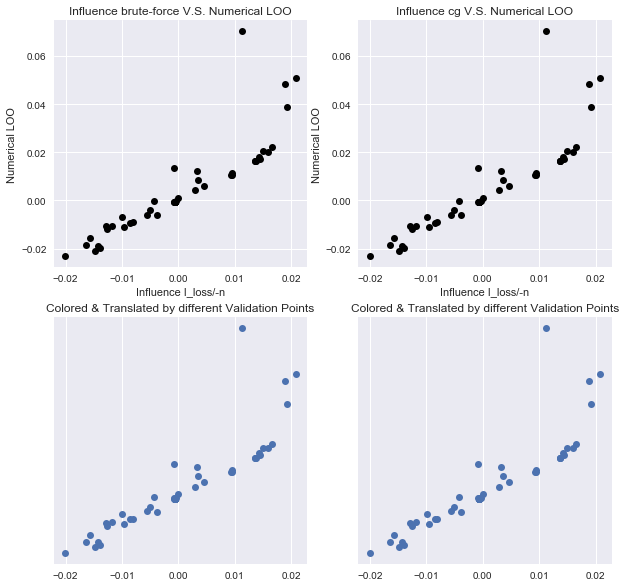

In [10]:
fig, axes = compare_with_loo(
    [I_loss_bf[:,0:1],
     I_loss_cg[:,0:1]],
    loo_diff, n_samples=n_tr
)

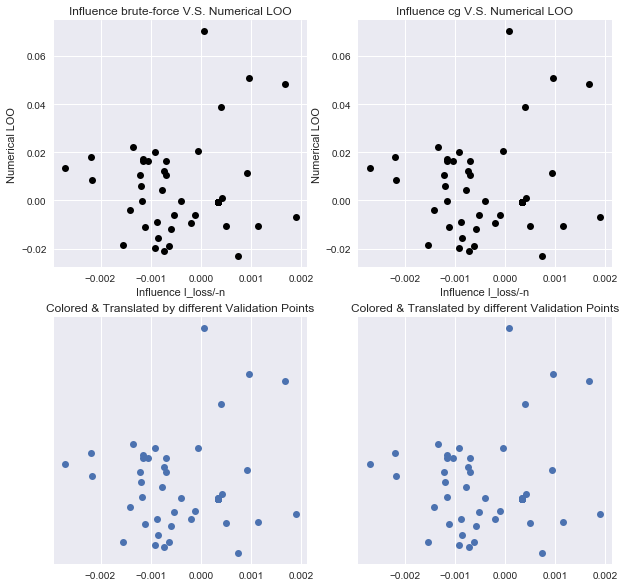

In [11]:
fig, axes = compare_with_loo(
    [I_loss_bf[:,1:2],
     I_loss_cg[:,1:2]],
    loo_diff, n_samples=n_tr
)

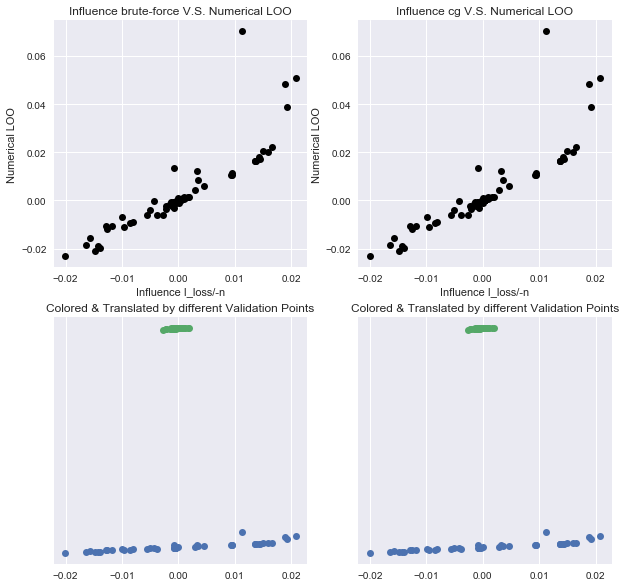

In [11]:
fig, axes = compare_with_loo(
    [I_loss_bf,
     I_loss_cg],
    loo_diff, n_samples=n_tr
)

In [12]:
a, b = loo_diff.shape
for j in range(n_te):
    print("Test Point %d Correlation: %.4f" % (j, np.corrcoef(
        I_loss_cg[:, j], loo_diff[:, j])[0][1]))
print("Overall Correlation: %.4f" % np.corrcoef(
        I_loss_cg[:, :].reshape(a*b,),
        loo_diff.reshape(a*b,))[0][1])

Test Point 0 Correlation: 0.8705
Test Point 1 Correlation: 0.9103
Overall Correlation: 0.8654
